In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import umap
from scipy import stats
pd.set_option('display.max_rows', 50)
np.set_printoptions(threshold=50)
import joblib
from scipy.stats import fisher_exact
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from matplotlib import cm
import statsmodels.api as sm
import pickle
from joblib import dump
from matplotlib.sankey import Sankey
import plotly.graph_objects as go
from joblib import load
import plotly.io as pio

# Load analysis datasets

In [2]:
with open('df_kmeans_rdm42_traditional5.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
with open('umap_results.pkl', 'rb') as file:
    X_embedded = pickle.load(file)

In [4]:
loaded_umap_model = load('umap_model.joblib')

Thu Oct  3 13:59:54 2024 Building and compiling search function


In [5]:
def categorize_diagnosis(count):
    if count <= 5:
        return '<=5'
    elif 6 <= count <= 49:
        return '6-49'
    else:
        return '50<='

In [6]:
# 新しい列 'diagnosis_category' を作成して、合併症数に応じて分類
df['diagnosis_category'] = df['#diagnosis'].apply(categorize_diagnosis)

## UMAP Visualization

In [ ]:
df

In [7]:
labels = df['diagnosis_category']

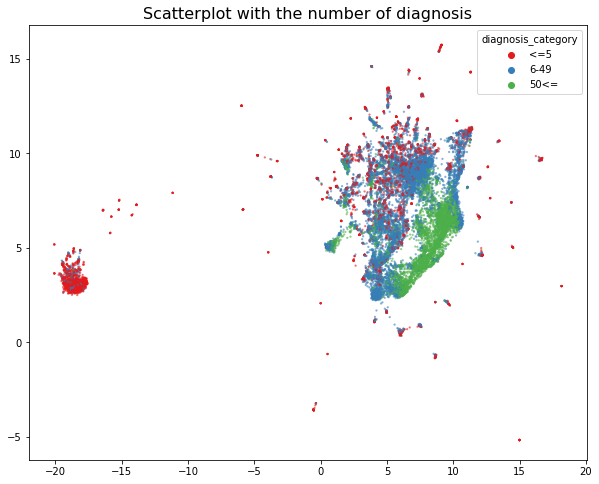

In [9]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = labels[reordered_indices], hue_order=['<=5', '6-49', '50<='],
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(facecolor='white')
    plt.title("Scatterplot with the number of diagnosis", fontsize=16)

In [14]:
UMAP_coordinates = pd.DataFrame(X_embedded, columns=['X','Y'])

In [17]:
UMAP_coordinates

,X,Y
0,4.028151,4.005666
1,4.709774,6.082903
2,5.002534,4.541701
3,8.048877,4.014426
4,7.729820,7.671883
...,...,...
21326,8.068508,8.887109
21327,8.179728,10.877392
21328,-3.759594,8.774329
21329,6.847869,10.359794


In [21]:
UMAP_coordinates['PatientID'] = df.index

In [31]:
df['PatientID'] = df.index

In [34]:
UMAP_coordinates.set_index('PatientID', inplace=True)

In [36]:
# インデックスを基に結合
UMAP_cluster = df.join(UMAP_coordinates, how='inner')

In [87]:
#UMAP_cluster .to_pickle("UMAP_SparseArea.pkl")

In [38]:
UMAP_cluster

,"""walking corpse"" syndrome",'light-for-dates' infant with signs of fetal malnutrition,(HFpEF) heart failure with preserved ejection fraction (HCC),(Idiopathic) normal pressure hydrocephalus (HCC),*Unknown,1st MTP arthritis,1st degree AV block,"2-part displaced fracture of surgical neck of right humerus, initial encounter for closed fracture","2-part displaced fracture of surgical neck of right humerus, subsequent encounter for fracture with routine healing","2-part nondisplaced fracture of surgical neck of left humerus, initial encounter for closed fracture",...,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster,diagnosis_category,PatientID,X,Y
PatientID,,,,,,,,,,,,,,,,,,,,,
D0003B2687D8F9,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,4,6-49,D0003B2687D8F9,4.028151,4.005666
D000D5B83D9620,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,4,6-49,D000D5B83D9620,4.709774,6.082903
D000D6884BD199,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,4,6-49,D000D6884BD199,5.002534,4.541701
D0016F824B7B74,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1,50<=,D0016F824B7B74,8.048877,4.014426
D00195531E21B1,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0,50<=,D00195531E21B1,7.729820,7.671883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DFFE8107CDA348,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0,50<=,DFFE8107CDA348,8.068508,8.887109
DFFF1B8ED4683F,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,4,6-49,DFFF1B8ED4683F,8.179728,10.877392
DFFF226D09433C,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,4,<=5,DFFF226D09433C,-3.759594,8.774329


In [40]:
x_min, x_max = [-25, -15]
y_min, y_max = [0,6]

In [41]:
filtered_data = UMAP_cluster[
    (UMAP_cluster['X'] >= x_min) & (UMAP_cluster['X'] <= x_max) &
    (UMAP_cluster['Y'] >= y_min) & (UMAP_cluster['Y'] <= y_max)
]

In [88]:
filtered_data.to_pickle("UMAP_SparseArea.pkl")

In [101]:
filtered_data_background = filtered_data[['Sex','Race','Age','#diagnosis','Death_Status','Cluster','isAD']]

In [102]:
filtered_data_background.to_csv("UMAP_SparseArea.csv", index=False)

In [43]:
labels = filtered_data['Cluster']

In [44]:
X_data = filtered_data['X']
Y_data = filtered_data['Y']

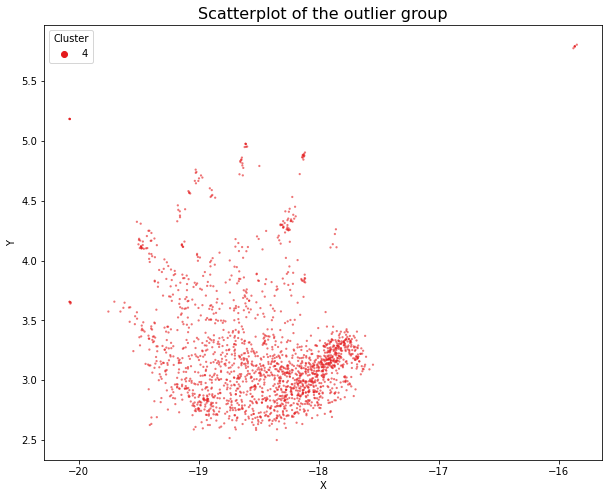

In [48]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_data.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_data[reordered_indices], y = Y_data[reordered_indices], 
                    hue = labels[reordered_indices],
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(facecolor='white')
    plt.title("Scatterplot of the outlier group", fontsize=16)

In [49]:
labels = filtered_data['isAD']

In [50]:
X_data = filtered_data['X']
Y_data = filtered_data['Y']

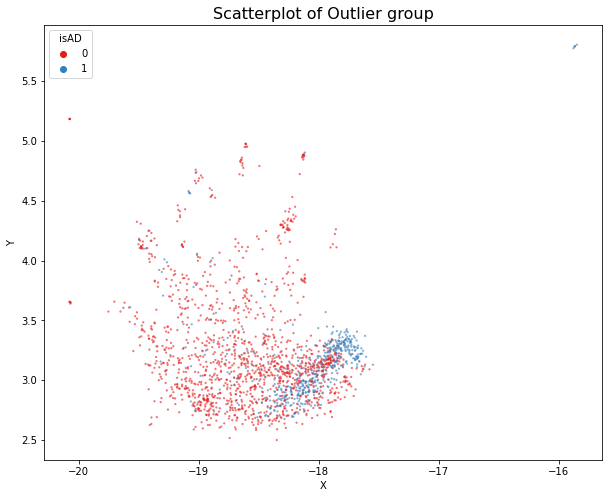

In [51]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_data.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_data[reordered_indices], y = Y_data[reordered_indices], 
                    hue = labels[reordered_indices],
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(facecolor='white')
    plt.title("Scatterplot of Outlier group", fontsize=16)

In [52]:
labels = filtered_data['Sex']

In [53]:
X_data = filtered_data['X']
Y_data = filtered_data['Y']

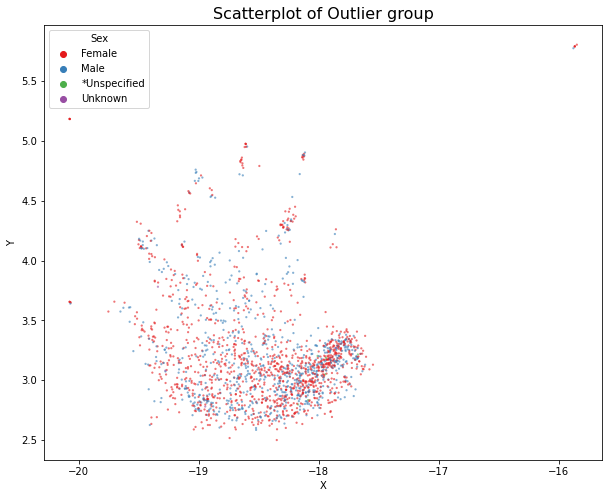

In [54]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_data.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_data[reordered_indices], y = Y_data[reordered_indices], 
                    hue = labels[reordered_indices],
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(facecolor='white')
    plt.title("Scatterplot of Outlier group", fontsize=16)

In [61]:
def categorize_diagnosis(count):
    if count <= 5:
        return '<=5'
    elif 6 <= count <= 49:
        return '6-49'
    else:
        return '50<='

In [62]:
# 新しい列 'diagnosis_category' を作成して、合併症数に応じて分類
filtered_data['diagnosis_category'] = filtered_data['#diagnosis'].apply(categorize_diagnosis)

/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [63]:
labels = filtered_data['diagnosis_category']

In [64]:
X_data = filtered_data['X']
Y_data = filtered_data['Y']

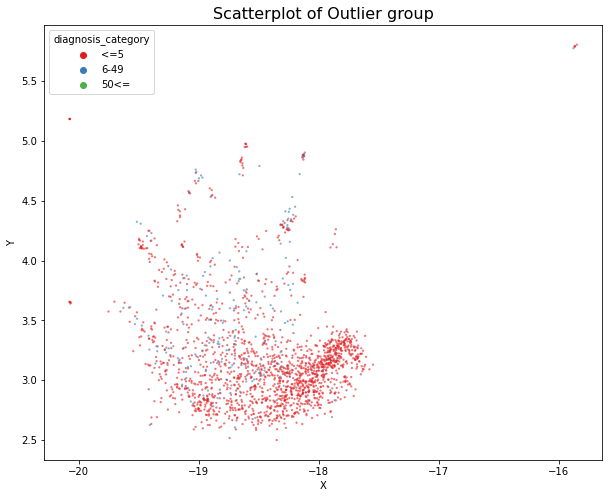

In [65]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_data.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_data[reordered_indices], y = Y_data[reordered_indices], 
                    hue = labels[reordered_indices], hue_order=['<=5', '6-49', '50<='],
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(facecolor='white')
    plt.title("Scatterplot of Outlier group", fontsize=16)

In [76]:
def categorize_age(age):
    if age <= 70:
        return '-70'
    elif 71 <= age <= 80:
        return '71-80'
    elif 81 <= age <= 90:
        return '81-90'
    elif 91 <= age:
        return '91-'
    else:
        return 'Unknown'

In [82]:
def categorize_age(age):
    if age <= 80:
        return '-80'
    elif 81 <= age <= 90:
        return '81-90'
    elif 91 <= age:
        return '91-'
    else:
        return 'Unknown'

In [83]:
# 新しい列 'diagnosis_category' を作成して、合併症数に応じて分類
filtered_data['age_category'] = filtered_data['Age'].apply(categorize_age)

/usr/local/icsoftware/anaconda3/envs/jupyterhub_base_v1.5/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [84]:
labels = filtered_data['age_category']

In [85]:
X_data = filtered_data['X']
Y_data = filtered_data['Y']

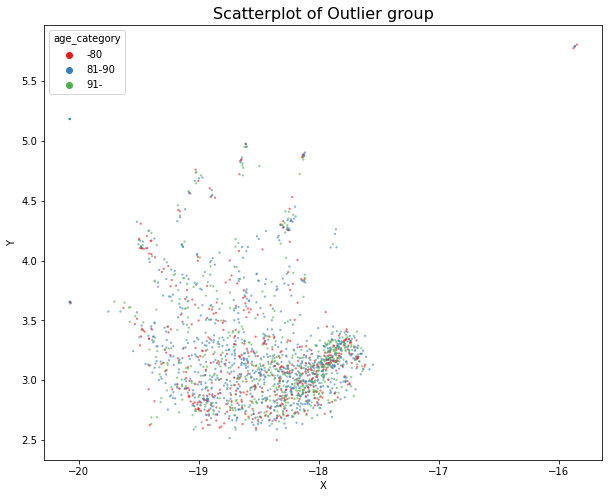

In [86]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_data.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_data[reordered_indices], y = Y_data[reordered_indices], 
                    hue = labels[reordered_indices], hue_order=['-80','81-90', '91-'],
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(facecolor='white')
    plt.title("Scatterplot of Outlier group", fontsize=16)

In [22]:
df.columns[-15:]

Index(['Zygomatic fracture, unspecified side, subsequent encounter for fracture with routine healing',
       'Zygomatic hyperplasia',
       'Zygomycosis (phycomycosis or mucormycosis) (HCC)', '#diagnosis', 'Age',
       'Sex', 'Race', 'Death_Status', 'Cluster_0', 'Cluster_1', 'Cluster_2',
       'Cluster_3', 'Cluster_4', 'Cluster', 'diagnosis_category'],
      dtype='object')

In [24]:
# 年齢に関する統計量
age_stats = df['Age'].agg(['mean', 'std', 'min', 'max', 'median']).rename('Age')

In [30]:
Ndiagnosis_stats = df['#diagnosis'].agg(['mean', 'std', 'min', 'max', 'median']).rename('#diagnosis')

In [31]:
Ndiagnosis_stats

mean       43.323942
std        70.986221
min         0.000000
max       990.000000
median     16.000000
Name: #diagnosis, dtype: float64

In [26]:
# カテゴリカルデータの集計
sex_counts = df['Sex'].value_counts().to_frame().T
sex_counts.index = ['Sex']

race_counts = df['Race'].value_counts().to_frame().T
race_counts.index = ['Race']

death_status_counts = df['Death_Status'].value_counts().to_frame().T
death_status_counts.index = ['Death_Status']


In [27]:
# デモグラフィックテーブルを作成
demographic_table = pd.concat([age_stats, sex_counts, race_counts, death_status_counts])

# 結果の表示
print(demographic_table)


                      0  *Unspecified      0    Alive  \
mean          86.330739           NaN    NaN      NaN   
std            6.444817           NaN    NaN      NaN   
min           65.000000           NaN    NaN      NaN   
max           91.000000           NaN    NaN      NaN   
median        90.000000           NaN    NaN      NaN   
Sex                 NaN          19.0    NaN      NaN   
Race                NaN           NaN  425.0      NaN   
Death_Status        NaN           NaN    NaN  15591.0   

              American Indian or Alaska Native   Asian  \
mean                                       NaN     NaN   
std                                        NaN     NaN   
min                                        NaN     NaN   
max                                        NaN     NaN   
median                                     NaN     NaN   
Sex                                        NaN     NaN   
Race                                      24.0  2484.0   
Death_Status          

In [28]:
# カテゴリカルデータの割合を計算
sex_percent = df['Sex'].value_counts(normalize=True).mul(100).to_frame().T
sex_percent.index = ['Sex (%)']

race_percent = df['Race'].value_counts(normalize=True).mul(100).to_frame().T
race_percent.index = ['Race (%)']

death_status_percent = df['Death_Status'].value_counts(normalize=True).mul(100).to_frame().T
death_status_percent.index = ['Death_Status (%)']

# 割合を結合
demographic_table_percent = pd.concat([age_stats, sex_counts, sex_percent, race_counts, race_percent, death_status_counts, death_status_percent])

print(demographic_table_percent)


                          0  *Unspecified           0         Alive  \
mean              86.330739           NaN         NaN           NaN   
std                6.444817           NaN         NaN           NaN   
min               65.000000           NaN         NaN           NaN   
max               91.000000           NaN         NaN           NaN   
median            90.000000           NaN         NaN           NaN   
Sex                     NaN     19.000000         NaN           NaN   
Sex (%)                 NaN      0.089072         NaN           NaN   
Race                    NaN           NaN  425.000000           NaN   
Race (%)                NaN           NaN    1.992405           NaN   
Death_Status            NaN           NaN         NaN  15591.000000   
Death_Status (%)        NaN           NaN         NaN     73.090807   

                  American Indian or Alaska Native        Asian  \
mean                                           NaN          NaN   
std          

In [37]:
df = df.reset_index()

In [39]:
df_subset = df[['#diagnosis', 'Age','Sex', 'Race', 'Death_Status', 'Cluster', 'diagnosis_category','PatientID']]

In [40]:
df_subset.to_csv('demographic_data.csv', index=False)